# Metric Benchmark

L'objectif de ce notebook est d'étudier la pertinence d'utiliser une autre métrique que la *LogLoss* Multiclass classique, dans le cadre de notre classification multiclass.

## I. Dataset loading

In [2]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
import sklearn.metrics as skl
import matplotlib.pyplot as plt
import os
import shutil
import random as rd
import numpy as np

homePath = "C:/Users/thoma/OneDrive - CentraleSupelec/NOPLP/code/ML"

# Import du fichier util
shutil.copy(homePath + "/util.py", homePath + "/etudes/")
import util

os.chdir(homePath)

# Chargement du dataset
print("Dataset loading...")
df = pd.read_csv("data/lossBenchmarkData.csv", sep=";")

# Data Cleaning
print("Data cleaning...")
df = df.drop(columns=['id', 'Chanson_id'])
reversed_cat = {'50': 1, '40': 2, '30': 3,
                '20': 4, '10': 5, 'MC': 6, '20k': 7, None: 8}
df = df.replace({'categorie': reversed_cat})

# Split train / test
print("Spliting in train and test...")
train = df[0:int(len(df)*0.8)]
print("Taille du dataset de train : " + str(len(train)))
test = df[int(len(df)*0.8)+1:]
print("Taille du dataset de test : " + str(len(test)))
train_labels = train['categorie']
trainSL = train.drop(columns=['categorie'])
train_data = trainSL
test_labels = test['categorie']
test = test.drop(columns=['categorie'])
test_data = test
test_pool = Pool(test_data,
                 test_labels,
                 cat_features=['titre', 'artiste', 'clusterid'])

Dataset loading...
Data cleaning...
Spliting in train and test...
Taille du dataset de train : 480160
Taille du dataset de test : 120040


## II. Multiclass

Let's test the Multiclass metric, with and without weight balancing

### 1. Sans poids

In [7]:
# Training model
cat_features = ['titre', 'artiste', 'clusterid']
model = util.trainModel(train_data, train_labels, cat_features)

Training the CatBoost model...


Predicting on the test set...
Confusion matrix :


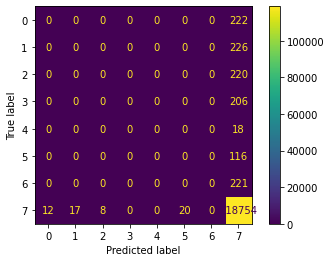

P5 = 0.0
P6 = 0.0
Precision = 0.0
R5 = 0.0
R6 = 0
Recall = 0.0
F1-score = 0


{'Precision': 0.0, 'Recall': 0.0, 'F1score': 0}

In [8]:
# Confusion matrix
confusionMatrix = util.confusionMatrixCalculation(model, test_pool, test_data, test_labels)
dispCM = skl.ConfusionMatrixDisplay(confusionMatrix)
dispCM.plot()
plt.show()

# Calcul des métriques
util.metricCalculation(confusionMatrix)

C'est de la demer

### 2. Avec poids

In [10]:
# Training model
cat_features = ['titre', 'artiste', 'clusterid']
class_weight = [0.1, 0.1, 0.1, 0.1, 0.1, 2, 1, 0.1]
print("Training the CatBoost model...")
model = CatBoostClassifier(iterations=10,
                            depth=10,
                            learning_rate=1,
                            loss_function='MultiClass',
                            class_weights=class_weight,
                            verbose=False)
model.fit(train_data, train_labels, cat_features=cat_features)

Training the CatBoost model...


Predicting on the test set...
Confusion matrix :


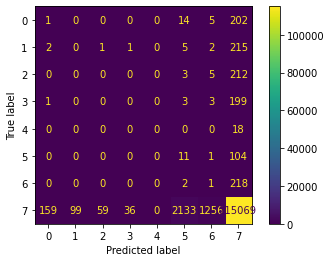

P5 = 9.5
P6 = 0.5
Precision = 8.6
R5 = 0.5
R6 = 0.1
Recall = 0.3
F1-score = 0.6


{'Precision': 8.6, 'Recall': 0.3, 'F1score': 0.6}

In [11]:
# Confusion matrix
confusionMatrix = util.confusionMatrixCalculation(model, test_pool, test_data, test_labels)
dispCM = skl.ConfusionMatrixDisplay(confusionMatrix)
dispCM.plot()
plt.show()

# Calcul des métriques
util.metricCalculation(confusionMatrix)

**Conclusion :** C'est un peu mieux mais ça reste de la demer. Pour une prédiction juste, on fait 100 erreurs.

## III. Multiclass One Vs All

### 1. Sans poids

In [12]:
# Training model
print("Training the CatBoost model...")
model = CatBoostClassifier(iterations=10,
                            depth=10,
                            learning_rate=1,
                            loss_function='MultiClassOneVsAll',
                            verbose=False)
model.fit(train_data, train_labels, cat_features=cat_features)

Training the CatBoost model...


Predicting on the test set...
Confusion matrix :


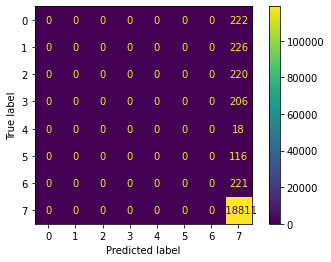

P5 = 0.0
P6 = 0.0
Precision = 0.0
R5 = 0
R6 = 0
Recall = 0.0
F1-score = 0


{'Precision': 0.0, 'Recall': 0.0, 'F1score': 0}

In [13]:
# Confusion matrix
confusionMatrix = util.confusionMatrixCalculation(model, test_pool, test_data, test_labels)
dispCM = skl.ConfusionMatrixDisplay(confusionMatrix)
dispCM.plot()
plt.show()

# Calcul des métriques
util.metricCalculation(confusionMatrix)

C'est pire !

### 2. Avec poids

In [14]:
print("Training the CatBoost model...")
class_weight = [0.1, 0.1, 0.1, 0.1, 0.1, 2, 1, 0.1]
model = CatBoostClassifier(iterations=10,
                            depth=10,
                            learning_rate=1,
                            loss_function='MultiClassOneVsAll',
                            class_weights=class_weight,
                            verbose=False)
model.fit(train_data, train_labels, cat_features=cat_features)

Training the CatBoost model...


Predicting on the test set...
Confusion matrix :


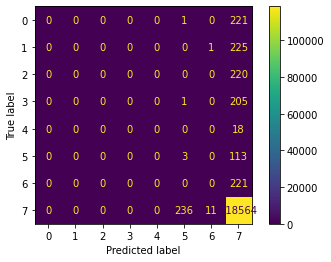

P5 = 2.6
P6 = 0.0
Precision = 2.3
R5 = 1.2
R6 = 0.0
Recall = 0.6
F1-score = 1.0


{'Precision': 2.3, 'Recall': 0.6, 'F1score': 1.0}

In [15]:
# Confusion matrix
confusionMatrix = util.confusionMatrixCalculation(model, test_pool, test_data, test_labels)
dispCM = skl.ConfusionMatrixDisplay(confusionMatrix)
dispCM.plot()
plt.show()

# Calcul des métriques
util.metricCalculation(confusionMatrix)

**Conclusion :** La méthode OneVsAll avec poids performe légèrement mieux que la méthode classique.

## IV. Grid Search pour les poids

On remarque donc que ce qui fonctionne le mieux est la loss OneVsAll avec des poids. On cherche maintenant à optimiser les poids à mettre sur chaque classe pour maximiser notre *F1-score* customisé.

In [4]:
petites = [0, 0.1, 0.3, 0.5, 1]
grandes = [0.25, 0.5, 1, 2, 5, 10]
cat_features = ['titre', 'artiste', 'clusterid']

N = 20
res = []

for i in range(N):
    
    # On choisit des poids au hasard
    class_weight = [petites[rd.randint(0,4)], petites[rd.randint(0,4)], petites[rd.randint(0,4)], petites[rd.randint(0,4)], petites[rd.randint(0,4)], grandes[rd.randint(0,4)], grandes[rd.randint(0,4)], petites[rd.randint(0,4)]]
    print(class_weight)
    # On entraine le modèle
    model = CatBoostClassifier(iterations=10,
                            depth=10,
                            learning_rate=1,
                            loss_function='MultiClassOneVsAll',
                            class_weights=class_weight,
                            verbose=False)
    model.fit(train_data, train_labels, cat_features=cat_features)
    # On calcule la matrice de confusion
    confusionMatrix = util.confusionMatrixCalculation(model, test_pool, test_data, test_labels)
    dispCM = skl.ConfusionMatrixDisplay(confusionMatrix)
    # On calcule le F1-score
    metriques = util.metricCalculation(confusionMatrix)

    res.append(class_weight + [metriques["F1score"]])

[1, 0.3, 0.1, 0.3, 0, 5, 5, 0.5]
Predicting on the test set...
Confusion matrix :
[0.1, 0.3, 1, 0, 1, 0.25, 0.25, 0.3]
Predicting on the test set...
Confusion matrix :
[0.5, 0.5, 0.5, 0.5, 0, 0.25, 0.25, 1]
Predicting on the test set...
Confusion matrix :
[0, 1, 0.3, 0.3, 0, 0.25, 5, 0.1]
Predicting on the test set...
Confusion matrix :
[0.1, 0.5, 0.1, 0, 1, 0.25, 5, 0.1]
Predicting on the test set...
Confusion matrix :
[1, 0.5, 1, 0.3, 1, 2, 1, 1]
Predicting on the test set...
Confusion matrix :
[0.3, 0.1, 0.3, 0.3, 0.1, 1, 1, 0.1]
Predicting on the test set...
Confusion matrix :
[0, 0, 0.1, 0.3, 0.3, 2, 1, 0.3]
Predicting on the test set...
Confusion matrix :
[0.5, 0.1, 0.3, 0.1, 0.3, 0.5, 5, 0]
Predicting on the test set...
Confusion matrix :
[0.5, 0, 1, 0.1, 0.1, 2, 0.5, 1]
Predicting on the test set...
Confusion matrix :
[0.1, 0.5, 0, 0.1, 0, 0.25, 5, 0]
Predicting on the test set...
Confusion matrix :
[0.3, 1, 0.5, 1, 0.1, 2, 0.5, 0]
Predicting on the test set...
Confusion matrix

In [5]:
dfRes = pd.DataFrame(np.array(res), columns = ["50", "40", "30", "20", "10", "MC", "20k", "PP", "F1score"])
dfRes.sort_values(by = "F1score", ascending = False)

,50,40,30,20,10,MC,20k,PP,F1score
10,0.1,0.5,0.0,0.1,0.0,0.25,5.00,0.0,0.8
8,0.5,0.1,0.3,0.1,0.3,0.50,5.00,0.0,0.8
12,0.1,1.0,0.5,0.5,0.3,5.00,5.00,0.0,0.8
11,0.3,1.0,0.5,1.0,0.1,2.00,0.50,0.0,0.8
16,0.0,1.0,0.3,0.3,0.0,5.00,0.25,0.1,0.4
19,0.0,0.0,0.5,1.0,0.3,5.00,1.00,0.1,0.4
4,0.1,0.5,0.1,0.0,1.0,0.25,5.00,0.1,0.2
6,0.3,0.1,0.3,0.3,0.1,1.00,1.00,0.1,0.0
7,0.0,0.0,0.1,0.3,0.3,2.00,1.00,0.3,0.0
5,1.0,0.5,1.0,0.3,1.0,2.00,1.00,1.0,0.0


Essayons de prendre la moyenne des poids obtenus pour le meilleur résultat

In [6]:
dfRes[dfRes['F1score'] >= 0.8].mean()

50         0.2500
40         0.6500
30         0.3250
20         0.4250
10         0.1750
MC         1.9375
20k        3.8750
PP         0.0000
F1score    0.8000
dtype: float64

## V. Grid Search pour les hyperparamètres d'entrainement

On optimise maintenant les hyperparamètres d'entrainement du modèle

In [10]:
class_weight = [0.25, 0.65, 0.325, 0.425, 0.175, 1.9375, 3.875, 0]
cat_features = ['titre', 'artiste', 'clusterid']

N = 20
res = []

for i in range(N):
    
    # On choisit des hyperparamètres au hasard
    iterations = rd.randint(1, 50)
    depth = rd.randint(1, 16)
    learning_rate = rd.uniform(0, 1)
    params = [iterations, depth, learning_rate]
    print(params)
    # On entraine le modèle
    model = CatBoostClassifier(iterations=iterations,
                            depth=depth,
                            learning_rate=learning_rate,
                            loss_function='MultiClassOneVsAll',
                            class_weights=class_weight,
                            verbose=False)
    model.fit(train_data, train_labels, cat_features=cat_features)
    # On calcule la matrice de confusion
    confusionMatrix = util.confusionMatrixCalculation(model, test_pool, test_data, test_labels)
    dispCM = skl.ConfusionMatrixDisplay(confusionMatrix)
    # On calcule le F1-score
    metriques = util.metricCalculation(confusionMatrix)

    res.append(params + [metriques["F1score"]])

[1, 8, 0.10978878415320348]
Predicting on the test set...
Confusion matrix :
[31, 9, 0.6406380688374607]
Predicting on the test set...
Confusion matrix :
[9, 14, 0.4396511801021109]
Predicting on the test set...
Confusion matrix :
[5, 9, 0.9682886011927002]
Predicting on the test set...
Confusion matrix :
[22, 5, 0.1394182588294156]
Predicting on the test set...
Confusion matrix :
[22, 7, 0.8833403864105397]
Predicting on the test set...
Confusion matrix :
[9, 9, 0.09427302711619512]
Predicting on the test set...
Confusion matrix :
[19, 5, 0.3967028327236978]
Predicting on the test set...
Confusion matrix :
[30, 8, 0.015285452737217597]
Predicting on the test set...
Confusion matrix :
[38, 4, 0.038864327730555925]
Predicting on the test set...
Confusion matrix :
[21, 14, 0.025853704952198298]
Predicting on the test set...
Confusion matrix :
[20, 9, 0.18752845003485474]
Predicting on the test set...
Confusion matrix :
[35, 1, 0.07742601863571574]
Predicting on the test set...
Confusion 

In [12]:
res

[[1, 8, 0.10978878415320348, 0.8],
 [31, 9, 0.6406380688374607, 0.8],
 [9, 14, 0.4396511801021109, 0.8],
 [5, 9, 0.9682886011927002, 0.8],
 [22, 5, 0.1394182588294156, 0.8],
 [22, 7, 0.8833403864105397, 0.8],
 [9, 9, 0.09427302711619512, 0.8],
 [19, 5, 0.3967028327236978, 0.8],
 [30, 8, 0.015285452737217597, 0.8],
 [38, 4, 0.038864327730555925, 0.8],
 [21, 14, 0.025853704952198298, 0.8],
 [20, 9, 0.18752845003485474, 0.8],
 [35, 1, 0.07742601863571574, 0.8],
 [19, 14, 0.9098949311231993, 0.8],
 [7, 12, 0.2653099052815695, 0.8],
 [11, 15, 0.011183130116869444, 0.8],
 [18, 14, 0.05647252855833129, 0.8],
 [16, 6, 0.3720560572436117, 0.8],
 [33, 4, 0.48546781267294326, 0.8],
 [48, 7, 0.31579108107092413, 0.8]]

In [11]:
dfRes = pd.DataFrame(np.array(res), columns = ["iterations", "depth", "eta", "F1score"])
dfRes.sort_values(by = "F1score", ascending = False)

,iterations,depth,eta,F1score
0,1.0,8.0,0.109789,0.8
1,31.0,9.0,0.640638,0.8
18,33.0,4.0,0.485468,0.8
17,16.0,6.0,0.372056,0.8
16,18.0,14.0,0.056473,0.8
15,11.0,15.0,0.011183,0.8
14,7.0,12.0,0.265310,0.8
13,19.0,14.0,0.909895,0.8
12,35.0,1.0,0.077426,0.8
11,20.0,9.0,0.187528,0.8
